In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Generation

In [2]:
def multi_gauss(mu, sigma):
    """
    Inputs
    ----------
    mu: mean of the Gaussian distribution
    sigma: covariance matrix of the Gaussian distribution
    
    Outputs
    -------
    logp: opposite of the loglikelihood
    """

    def logpr(x):
        if type(x)==torch.Tensor:
            x_ = x.detach().numpy()
        k   = mu.shape[0]
        cst       = k * np.log(2 * np.pi)
        det       = np.log(np.linalg.det(sigma))
        print(sigma)
        print(type(x-mu))
        first_term = torch.matmul(torch.tensor(x-mu).T,torch.linalg.inv(torch.tensor(sigma)))
        quad_term = torch.matmul(first_term, torch.tensor(x - mu))
        return (cst +  det + quad_term) * 0.5
    
    return logpr

def mixture(log_prob, weights):
    """
    Inputs
    ----------
    log_prob: opposite of the likelihood of each term
    weights: weights of the components of the mixture
    
    Outputs
    -------
    logp: opposite of the loglikelihood of the mixture
    """
    
    def logp(x):
        likelihood = 0
        print(type(x))
        if type(x) == torch.Tensor:
            x = x.detach().numpy()
        for j in range(np.size(weights)):
            log_marginal = -log_prob[j](x)
            likelihood   = likelihood + weights[j]*np.exp(log_marginal)
        
        return -np.log(likelihood)

    return logp

In [3]:
def generate_isotropic_gmm_data(d, N, scale_factor=1.0):
    #generates our data points and gives us the log_likelihood of each component of the mixture.
    #M lois gaussiennes dans R^d 
    
    M = int(np.log2(d))
    R = 2 * np.abs(np.log2(d))
    means = np.random.uniform(-R, R, size=(M, d))
    covariances = np.eye(d) * scale_factor
    weights = np.ones(M) / M
    
    # generate our data points
    data = []
    for _ in range(N):
        # choose the mixture component
        mixture_idx = np.random.choice(M, p=weights)
        mean = means[mixture_idx]
        data.append(np.random.multivariate_normal(mean, covariances)) #d et pas 1/d? 
        
    marg_likelihood = []
    for i in range(M):
        marg_likelihood.append(multi_gauss(means[i],covariances))
    
    likelihood = mixture(marg_likelihood,weights)
    
    return np.array(data), means, marg_likelihood, likelihood

In [4]:
d = 8
n_comp = int(np.log2(d))
N = 2**d
scale_factor = 1.0
synthetic_data, true_means, marg_likelihoods, likelihood = generate_isotropic_gmm_data(d, N, scale_factor)
print("Synthetic dataset shape:", synthetic_data.shape)

Synthetic dataset shape: (256, 8)


In [5]:
R = 2 * np.abs(np.log2(d))
means = np.random.uniform(-R, R, size=(3, 8))

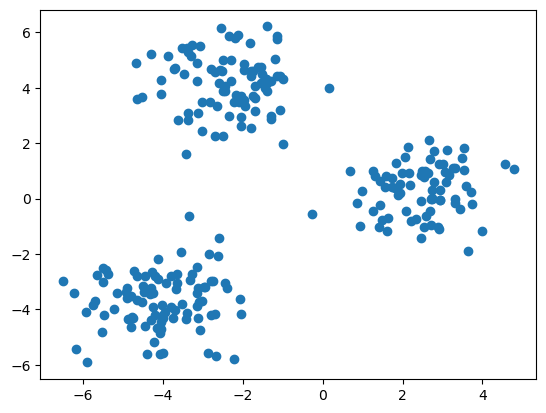

In [6]:
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1])

In [7]:
synthetic_data[:,0]

array([-5.71263896, -3.64301833, -3.14544663,  1.93954331,  2.17723035,
       -1.62242506, -4.05963016, -3.12943194,  1.89112739, -1.29933574,
        0.15297824, -1.14204486,  1.40436659, -1.38647631,  2.70833611,
        2.63270084, -2.97973956, -2.81025956,  2.7925057 , -2.68375346,
        0.86478143, -3.43101084,  1.7343205 ,  2.7953484 , -1.79910997,
        3.54998708,  1.84596748, -1.53269513, -3.02826012,  2.59296025,
        3.6339103 , -1.06247885,  2.54899344, -5.3816225 ,  3.59553595,
        2.90692409, -5.4899503 , -2.21787236,  4.57873573,  2.68186276,
        2.45176874,  2.6911254 , -2.05270014, -5.64929264, -3.86661487,
       -2.09854741, -3.40822374, -2.43798622,  3.07482114, -3.14819293,
       -1.98157827, -4.13461844,  1.42629899,  1.49363928, -3.9993929 ,
        1.60035048,  1.55209859, -4.50236482, -4.77727229, -3.53193111,
       -2.04993132, -3.3855659 , -3.69991851, -3.14661255, -5.75600957,
       -2.79588529, -4.05233052, -5.43061492,  2.71611759, -3.07

## EM algorithm

### Expectation-Maximization Algorithm for Gaussian Mixture Models

The Expectation-Maximization (EM) algorithm is an iterative method for finding the maximum likelihood estimates of parameters in statistical models, particularly useful for unsupervised learning tasks like clustering. In the context of Gaussian Mixture Models (GMM), the EM algorithm iteratively optimizes the parameters of multiple Gaussian distributions to fit the observed data.

#### Algorithm Steps:

1. **Initialization**: Start by initializing the parameters of the Gaussian components: means, covariances, and mixing coefficients.

2. **Expectation Step (E-step)**:
   - Compute the responsibilities (likelihoods) of each data point belonging to each Gaussian component.
   - Responsibilities are computed based on the current parameters using the multivariate normal distribution.

3. **Maximization Step (M-step)**:
   - Update the parameters (means, covariances, and mixing coefficients) using the responsibilities computed in the E-step.
   - Expressions for updating parameters:
     - **Means**: Weighted average of data points using responsibilities.
     - **Covariances**: Weighted covariance matrix of data points using responsibilities.
     - **Mixing Coefficients**: Mean of responsibilities.

4. **Compute Log-Likelihood**:
   - Compute the log-likelihood of the data given the current parameters and responsibilities.
   - Log-likelihood serves as a measure of how well the model fits the data.

5. **Convergence Check**:
   - Iterate between the E-step and M-step until convergence, typically based on a convergence criterion such as changes in log-likelihood or parameter values.

#### Expressions for Updating Parameters:

- **Means**: 

$$ \mu_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) \cdot x_i}{\sum_{i=1}^{N} \gamma(z_{ik})} $$

- **Covariances**:
  $$ \Sigma_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) \cdot (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^{N} \gamma(z_{ik})} $$

- **Mixing Coefficients**:
  $$ \pi_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik})}{N} $$

Here, $ \gamma(z_{ik}) $ represents the responsibility of data point $ x_i $ belonging to Gaussian component $ k $.



In [8]:
import numpy as np
from scipy.stats import multivariate_normal

def initialize_parameters(data, num_components):
    num_data_points, num_features = data.shape
    # Initialize means randomly
    means = np.random.rand(num_components, num_features)
    # Initialize covariances as identity matrices
    covariances = [np.eye(num_features)] * num_components
    # Initialize mixing coefficients uniformly
    mixing_coefficients = np.ones(num_components) / num_components
    return means, covariances, mixing_coefficients

def expectation_step(data, means, covariances, mixing_coefficients):
    num_data_points = len(data)
    num_components = len(means)
    responsibilities = np.zeros((num_data_points, num_components))

    for i in range(num_data_points):
        for j in range(num_components):
            responsibilities[i, j] = mixing_coefficients[j] * multivariate_normal.pdf(data[i], means[j], covariances[j])

    # Normalize the responsibilities
    responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]

    return responsibilities

def maximization_step(data, responsibilities):
    num_data_points, num_components = responsibilities.shape
    num_features = data.shape[1]
    means = np.zeros((num_components, num_features))
    covariances = [np.zeros((num_features, num_features))] * num_components
    mixing_coefficients = np.zeros(num_components)

    for j in range(num_components):
        # Update means
        means[j] = np.sum(responsibilities[:, j][:, np.newaxis] * data, axis=0) / np.sum(responsibilities[:, j])

        # Update covariances
        diff = data - means[j]
        covariances[j] = np.dot((responsibilities[:, j][:, np.newaxis] * diff).T, diff) / np.sum(responsibilities[:, j])

        # Update mixing coefficients
        mixing_coefficients[j] = np.mean(responsibilities[:, j])

    return means, covariances, mixing_coefficients

def em_algorithm(data, num_components, max_iterations=100, tolerance=1e-60,criterion=0, early_stopping=True):
    means, covariances, mixing_coefficients = initialize_parameters(data, num_components)
    prev_log_likelihood = float('-inf')

    for iteration in range(max_iterations):
        responsibilities = expectation_step(data, means, covariances, mixing_coefficients)
        means, covariances, mixing_coefficients = maximization_step(data, responsibilities)

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
        print(f"Likelihood difference: {log_likelihood - prev_log_likelihood}")

        # Check for convergence
        cvg = criterion if criterion!=0 else prev_log_likelihood
        if early_stopping and abs(log_likelihood - cvg) < tolerance:
            break
        

        prev_log_likelihood = log_likelihood

    return means, covariances, mixing_coefficients,log_likelihood

num_components = n_comp # Number of Gaussian components
means, covariances, mixing_coefficients, _ = em_algorithm(synthetic_data, num_components)
print("Means:", means)
print("Covariances:", covariances)
print("Mixing Coefficients:", mixing_coefficients)

Likelihood difference: inf
Likelihood difference: -4.4408920985006183e-16
Likelihood difference: 1.4432899320127035e-15
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.9984014443252818e-15
Likelihood difference: -3.219646771412954e-15
Likelihood difference: 2.220446049250313e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.3322676295501878e-15
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: 0.0
Means: [[ 2.46639006  0.30280179 -4.62784321  0.47858325  5.26377148 -5.04322049
   0.12697179  2.0062271 ]
 [-4.06424773 -3.6770276  -2.76218571 -3.34293302 -1.25861704  2.01702298
   4.84260881  4.84011851]
 [-2.36278207  4.16888235  1.01636588 -0.51683483 

In [9]:
# Estimation of the reference value mu_star_hat by running EM 1000 times longer than required

est_em_means, est_em_cov, est_em_mixing,est_log_likelihood = em_algorithm(synthetic_data, num_components, 4500,early_stopping=False)

Likelihood difference: inf
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -2.1094237467877974e-15
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 2.3314683517128287e-15
Likelihood difference: -3.3306690738754696e-16
Likeli

Likelihood difference: -9.992007221626409e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 0.0
Likelihood difference: -2.4424906541753444e-15
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 1.9984014443252818e-15
Likelihood difference: 1.887379141862766e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -2.4424906541753444e-15
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 1.9984014443252818e-15
Likelihood difference: -1.6653345369377348e-15
Likelihood difference: 1.4432899320127035e-15
Likelihoo

Likelihood difference: 2.220446049250313e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -1.7763568394002505e-15
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 2.6645352591003757e-15
Likelihood difference: -1.554312234475219e-15
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -2.1094237467877974e-15
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -7.77156117

Likelihood difference: -9.992007221626409e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -9.992007221626

Likelihood difference: 2.4424906541753444e-15
Likelihood difference: -1.887379141862766e-15
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 1.887379141862766e-15
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -1.7763568394002505e-15
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -1.7763568394002505e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 1.4432899320127035e-15
Likelihood difference: -2.553512956637

Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 1.3322676295501878e-15
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 2.3314683517128287e-15
Likelihood difference: -7.771561172376096e-16
Likelihood difference: -1.5543122344752192e-15
Likelihood difference: 1.4432899320127035e-15
Likelihood difference: -7.771561172376096e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 1.776356

Likelihood difference: 1.9984014443252818e-15
Likelihood difference: -1.7763568394002505e-15
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 0.0
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -1.887379141862766e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -2.7755575615628914e-15
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.3322676295501878e-15
Likelihood difference: 1.4432899320127035e-15
Like

Likelihood difference: 8.881784197001252e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 0.0
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 3.3306690738754696e-16
Likelihoo

Likelihood difference: -8.881784197001252e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 1.5543122344752192e-15
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 1.3322676295501878e-15
Likelihood difference: -8.881784197001252e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 2.220446049250313e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -3.330669073

Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 2.3314683517128287e-15
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -2.55351295663786e-15
Likelihood difference: 1.3322676295501878e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -1.6653345369377348e-15
Likelihood difference: 1.4432899320127035e-15
Likelihood difference: -1.5543122344752192e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 5.55111512312

Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -7.771561172376096e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 0.0
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -2.220446049250313e-16
Likelih

Likelihood difference: 0.0
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: 0.0
Likelihood difference: 9.992007221626409e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.33226

Likelihood difference: 1.1102230246251565e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -1.5543122344752192e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 2.220446049250313e-15
Likelihood difference: -1.9984014443252818e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -3.330669073875

Likelihood difference: 6.661338147750939e-16
Likelihood difference: 1.3322676295501875e-15
Likelihood difference: -1.8873791418627657e-15
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 1.3322676295501878e-15
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -2.886579864025407e-15
Likelihood difference: 1.4432899320127035e-15
Likelihood difference: 0.0
Likelihood difference: 0.0
Likelihood difference: 9.992007221626409e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -1.887379141862766e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -1.66

Likelihood difference: -1.7763568394002505e-15
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 2.1094237467877974e-15
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -2.3314683517128287e-15
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 1.887379141862766e-15
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: -7.771561172376096e-16
Likelihood difference: -3.330669073

Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -1.5543122344752192e-15
Likelihood difference: 0.0
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -1.7763568394002505e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -1.887379141862766e-15
Likelihood difference: 2.4424906541753444e-15
Likelihood difference: -6.661338147750939e-16
Likelihood difference: -1.3322676295501878e-15
Likelihood difference: 1.5543122344752192e-15
Likelihood difference: -9.992007221626409e-16
Likeliho

Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 1.5543122344752192e-15
Likelihood difference: -7.771561172376096e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -8.881784197001252e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 1.7763568394002505e-15
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 0.0
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 2.220446049250313e-16
Likelihoo

Likelihood difference: -6.661338147750939e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 0.0
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 1.3322676295501878e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 0.0
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -2.220446049250313e-15
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -3.

Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 1.4432899320127035e-15
Likelihood difference: -6.661338147750939e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -1.7763568394002505e-15
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -2.220446049

Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 1.7763568394002505e-15
Likelihood difference: -1.4432899320127035e-15
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -1.3322676295501878e-15
Likelihood difference: 5.551115123125783e-16
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -9.992007221626409e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -9.992007221626409e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: 3.33066907

Likelihood difference: -1.3322676295501878e-15
Likelihood difference: -1.6653345369377348e-15
Likelihood difference: 9.992007221626409e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.3322676295501878e-15
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -1.5543122344752192e-15
Likelihood difference: -9.992007221626409e-16
Likelihood difference: 1.3322676295501878e-15
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: 1.5543122344752192e-15
Likelihood difference: -2.1094237467877974e-15
Likelihood difference: 1.33226762

Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 0.0
Likelihood difference: 0.0
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 0.0
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -1.3322676295501878e-15
Likelihood difference: 0.0
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 

Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 1.2212453270876722e-15
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 0.0
Likelihood difference: -1.9984014443252818e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: 1.4432899320127035e-15
Likelihood difference: -4.440892098500626e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 1.6653345369377348e-15
Likelihood difference: -8.881784197001252e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 1.1102230246251565e-16
Likeli

Likelihood difference: -8.881784197001252e-16
Likelihood difference: -6.661338147750939e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.5543122344752192e-15
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: 0.0
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -7.771561172376096e-16
Likelihood difference: -9.992007221626409e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: 8.881784197001252e-16
Likelihood difference: 0.0
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.7763568394002505e-15
Likelihood difference: 9.992007221626409e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: 0.0
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -9.992007221626409e-16
Li

Likelihood difference: -6.661338147750939e-16
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: -8.881784197001252e-16
Likelihood difference: 6.661338147750939e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -7.771561172376096e-16
Likelihood difference: 2.1094237467877974e-15
Likelihood difference: -1.6653345369377348e-15
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 1.9984014443252818e-15
Likelihood difference: -1.2212453270876722e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 3.3306690738754696e-16
Likelihood difference: -4.440892098500626e-16
Likelihood difference: 1.1102230246251565e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 0.0
Likelihood difference: 5.551115123125783e-16
Likelihood difference: -6.661338147750939e-16
Likeliho

In [10]:
means, cov, mixing,_ = em_algorithm(synthetic_data, num_components, 4500,tolerance=1e-6, criterion=est_log_likelihood, early_stopping=True)

Likelihood difference: inf


In [11]:
print(means)
print(true_means)

[[-0.43036662  1.76983053 -1.32597572 -0.27971369  4.22261135 -0.50177169
  -1.88957763  2.19192595]
 [-3.92310891 -2.67330892 -2.32724553 -2.96391842 -0.6244696   2.05700639
   3.90227084  4.39428979]
 [ 0.26383722  2.16201229 -2.18981459 -0.04913489  4.75567235 -1.65914331
  -1.5626536   1.55401731]]
[[-2.57307107  4.30962939  1.06220745 -0.66012476  4.09469728  2.54606245
  -3.84218149  1.26939527]
 [-4.15757087 -3.77744725 -2.68754048 -3.42507799 -1.32887724  1.92497463
   4.86728733  4.69243242]
 [ 2.57715696  0.14108579 -4.63033289  0.63049875  5.50588835 -4.91078637
  -0.11668133  1.91978119]]


## MALA

In [12]:
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import torch
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm

In [13]:
def accept_filter(log_ratio, x, x_init):

    log_u = torch.log(torch.rand_like(log_ratio))
    acc = log_u < log_ratio
    x[~acc] = x_init[~acc]

    return x, acc

def get_grad(U):
    """
    Function to get grad of input function via autodiff
   
    U: function with single tensor input
    """
    @torch.enable_grad()
    def grad_U(x):
        x = x.clone().detach().requires_grad_()
        return torch.autograd.grad(U(x).sum(), x)[0]
    
    return grad_U


def run_mala(target_U, x_init, n_steps=1000, dt=0.005, beta_eff=1, with_tqdm=False,cvg=False,criterions=[0,0]):
    """
    target_U: function - target potential we will run the Langevin on (negative log prob)
    x (tensor): init points for the chains to update (batch_dim, dim)
    dt : time step
    beta_eff: additional control to change temperature of target U
    cvg: bool - runs the code until convergence criterions are met. if false, runs the code for n_steps 
    criterions: list - the two tolerances for the convergence criterions. The first one uses the empirical mean of the log_likelihood of the generated sample, the second one uses the empirical mean of the sample.
    """
    grad_U = get_grad(target_U)
    def step(target_U, grad_U, x_init, n_steps, dt, beta_eff):
        """
        One step of the mala algorithm.
        """
        
        x = x_init.clone()
        x = x_init - dt * grad_U(x_init)
        if dt > 0:
            x += dt * np.sqrt(2 / (dt * beta_eff)) * torch.randn_like(x_init)

        log_ratio = -target_U(x)
        log_ratio -= ((x_init - x + dt * grad_U(x)) ** 2 / (4 * dt)).sum()
        log_ratio += target_U(x_init)  # Reshape to match the shape of log_ratio
        log_ratio += ((x - x_init + dt * grad_U(x_init)) ** 2 / (4 * dt)).sum()
        log_ratio = beta_eff * log_ratio

        x, acc = accept_filter(log_ratio, x, x_init)

        accs.append(acc)
        xs.append(x.clone())
        x_init = x.clone().detach()
        
        return xs,x_init,acc
    
    xs = []
    accs = []

    range_ = tqdm.tqdm(range(n_steps)) if with_tqdm else range(n_steps)
    if not cvg:
        
        for t in range_:
            xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
            
    
    else:
        t=1
        crit_1 = np.inf
        crit_2 = np.inf
        sum_logprob_mala = 0
        
        
        while crit_1>1e-6  or crit_2>1e-3:
            if not xs: #make sure we do not run the code as long as we did not accept a x.
                t+=1
                xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
            else:
                xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
                x_temp = torch.stack(xs)
                sum_logprob_mala += U(xs[-1])
                crit_1 = abs(sum_logprob_mala/t - criterions[0])
                
                empirical_mean=(torch.sum(x_temp,dim=0)/t).T
                crit_2 = np.linalg.norm(empirical_mean - criterions[1])
                print(crit_1)
                print(crit_2)
                t+=1
                if t%100:
                    print(f"iteration n°{t}")
        print(f"end of the loop. Number of iterations: {t}")
                
    return torch.stack(xs), torch.stack(accs)

In [14]:
# function that returns a function that computes the negative log probability of a given dataset
def get_log_prob(data):
    N = data.shape[0]
    d = data.shape[1]
    R = 2 * np.abs(np.log2(d))

    def log_mu_prior(mu):
        M = mu.shape[1]
        return -(torch.norm(mu) - np.sqrt(M) * R) ** 2 * int(torch.norm(mu) > np.sqrt(M) * R)

    def log_prob(mu):
        # Compute squared distances between each data point and each mean
        squared_distances = torch.sum((data.unsqueeze(1) - mu.t().unsqueeze(0)) ** 2, dim=2)

        # Compute the log probabilities for each data point and each mixture component
        log_probs = -0.5 * squared_distances / (1000 * data.shape[1])

        # Sum over mixture components and take the log-sum-exp to compute the log probability
        max_log_probs, _ = torch.max(log_probs, dim=1, keepdim=True)
        log_prob_ = torch.log(torch.sum(torch.exp(log_probs - max_log_probs), dim=1)) + max_log_probs.squeeze()

        return -torch.sum(log_prob_)

    return log_prob

In [15]:
grad_likelihood = get_grad(likelihood)
n_steps=50_000 #arbitrarly large number
M = int(np.log2(d))
x_init = torch.Tensor(synthetic_data[:M, :].T)

In [16]:
likelihood(x_init.T[0])
# me reste à faire en sorte que ça marche avec x_init, pas x_init[0]

<class 'torch.Tensor'>
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
<class 'numpy.ndarray'>
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
<class 'numpy.ndarray'>
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
<class 'numpy.ndarray'>


C:\Users\rayan\AppData\Local\Temp\ipykernel_9492\265970731.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  first_term = torch.matmul(torch.tensor(x-mu).T,torch.linalg.inv(torch.tensor(sigma)))


tensor(13.2705, dtype=torch.float64)

In [17]:
n_steps=50_000 #arbitrarly large number
mean_estimates=[]
logprob_estimates=[]
for i in range(0,2):
    objective_estimation, objective_accs = run_mala(U, grad_U, x_init, n_steps, dt=0.005)
    empirical_mean=(torch.sum(objective_estimation,dim=0)/n_steps).T
    log_prob_mala=0
    
    for j in range(n_steps):
        log_prob_mala += U(objective_estimation[j])/n_steps
    
        mean_estimates.append(empirical_mean)
        logprob_estimates.append(log_prob_mala)

NameError: name 'U' is not defined

In [ ]:
log_prob_mala=0
mean_estimates=[]
logprob_estimates=[]
for j in range(n_steps):
        log_prob_mala += U(objective_estimation[j])/n_steps
    
        mean_estimates.append(empirical_mean)
        logprob_estimates.append(log_prob_mala)

In [ ]:
crit1 = sum(logprob_estimates)/len(logprob_estimates)
crit2 = sum(mean_estimates)/len(mean_estimates)

In [ ]:
crit2 - true_means

In [ ]:
xs, accs,c = run_mala(U, grad_U, x_init, dt=0.005,cvg=True,criterions=[crit1,crit2])